In [1]:
__author__ = "me"
__date__ = "2015_10_13"

%pylab inline
import pandas as pd
import numpy as np
import geopandas as gp

import pylab as plt
import os

from scipy import stats

import requests
s = requests.get("https://raw.githubusercontent.com/Casyfill/CUSP_templates/master/Py/fbMatplotlibrc.json").json()
plt.rcParams.update(s)


Populating the interactive namespace from numpy and matplotlib


/Users/casy/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:855: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
PARQA = os.getenv('PARQA')
path = PARQA + "data/Input/Parks_Data/PIP_InspectionMain.xlsx"

## Reading Data

In [11]:
df = pd.read_excel(path)

In [12]:
df = df[(pd.notnull(df.BeginInspection) ) &  (pd.notnull(df.EndInspection))]

## Parsing times

In [13]:
df['BeginInspection'] = df['BeginInspection'].astype(str)
df['EndInspection'] = df['EndInspection'].astype(str)

In [14]:
df['BeginInspection'] = df['BeginInspection'].str.replace('AN', 'AM').str.replace('OM','PM')

In [15]:
df['BeginInspection_d'] = pd.to_datetime(df.BeginInspection, format="%H:%M:%S", errors='coerce') # 

In [16]:
# df.head(2)

In [17]:
df['BeginInspection_d'][pd.isnull(df['BeginInspection_d'])] = pd.to_datetime(df.BeginInspection[pd.isnull(df['BeginInspection_d'])], format="%I:%M %p", errors='coerce') # 

/Users/casy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [18]:
ok = df[pd.notnull(df['BeginInspection_d'])]
nok = df[pd.isnull(df['BeginInspection_d'])]
len(nok)

7

In [19]:
nok = nok[nok.BeginInspection != 'Dec 30 1']
nok.BeginInspection = nok.BeginInspection.str.replace('8AM','8 AM')
nok.BeginInspection = nok.BeginInspection.str.replace('9:','09:').str.strip()
nok.BeginInspection = nok.BeginInspection.str.replace('13:','01:')
# nok

In [20]:
nok['BeginInspection_d'] = pd.to_datetime(nok['BeginInspection'], format="%I:%M %p") # 

In [21]:
df2 = pd.concat([ok,nok])

In [22]:
# df2.head()

## Parsing EndInspections

In [23]:
df2['EndInspection_d'] = pd.to_datetime(df2.EndInspection, format="%H:%M:%S", errors='coerce') # 

In [24]:
# df2[pd.isnull(df2.EndInspection_d)]

In [25]:
df2.EndInspection[pd.isnull(df2.EndInspection_d)] = df2.EndInspection[pd.isnull(df2.EndInspection_d)].str.replace('OM','PM')
df2.EndInspection[pd.isnull(df2.EndInspection_d)] = df2.EndInspection[pd.isnull(df2.EndInspection_d)].str.replace('9:','09:').str.strip()
df2.EndInspection[pd.isnull(df2.EndInspection_d)] = df2.EndInspection[pd.isnull(df2.EndInspection_d)].str.replace('13:','01:')
df2.EndInspection_d[pd.isnull(df2.EndInspection_d)] = pd.to_datetime(df2.EndInspection[pd.isnull(df2.EndInspection_d)], format="%I:%M %p") # 

/Users/casy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/casy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/casy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/casy/anaconda/lib/python2.7/sit

## Timedelta

In [26]:
## time in minutes
df2['timeSpent'] = (df2['EndInspection_d'] - df2['BeginInspection_d']).dt.seconds/60

In [27]:
## where they messed up
newDay = datetime.timedelta(hours=8)
df2['timeSpent'][df2.BeginInspection_d > df2.EndInspection_d] = (df2['EndInspection_d'] + newDay - df2['BeginInspection_d'] ).dt.seconds/60

/Users/casy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


## Turns out this data is mess: a lot of records with finishing

In [28]:
# df2[df2.BeginInspection_d > df2.EndInspection_d]

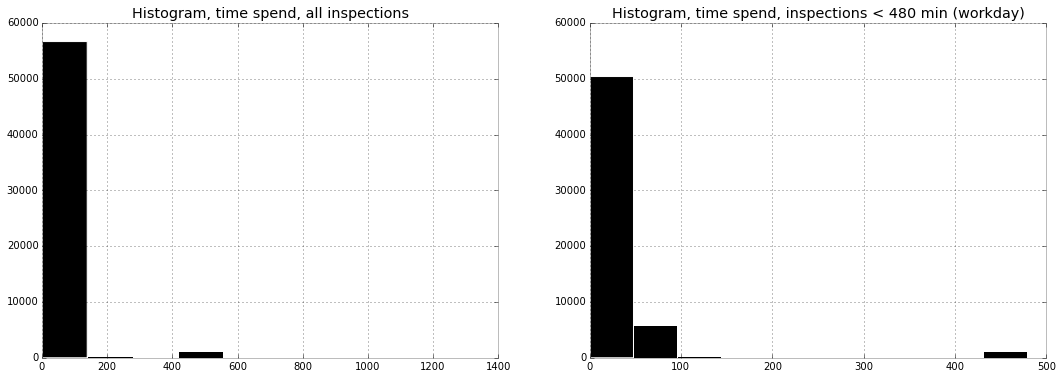

In [29]:
fig, axes = plt.subplots(1,2, figsize=(18,6))

df2.timeSpent.hist(color='k', ax = axes[0]) ## less than one workday
df2.timeSpent[df2.timeSpent<480].hist(color='k', ax = axes[1]);

axes[0].set_title('Histogram, time spend, all inspections')
axes[1].set_title('Histogram, time spend, inspections < 480 min (workday)');

In [30]:
# df2.sort_values('timeSpent',ascending=0).head(4) ### HOW TO INTERPRET THOSE?

# Frome Here working with inspections < 8 hours

In [31]:
df3 = df2[['Overall Condition','Cleanliness','Unacceptable Features','Season','Inspection Year','Prop ID','timeSpent']]
df3 = df3[df3.timeSpent < 480]

In [32]:
df3['boro'] = df3['Prop ID'].str[0]

'/Users/casy/Dropbox/CUSP/GRA/'

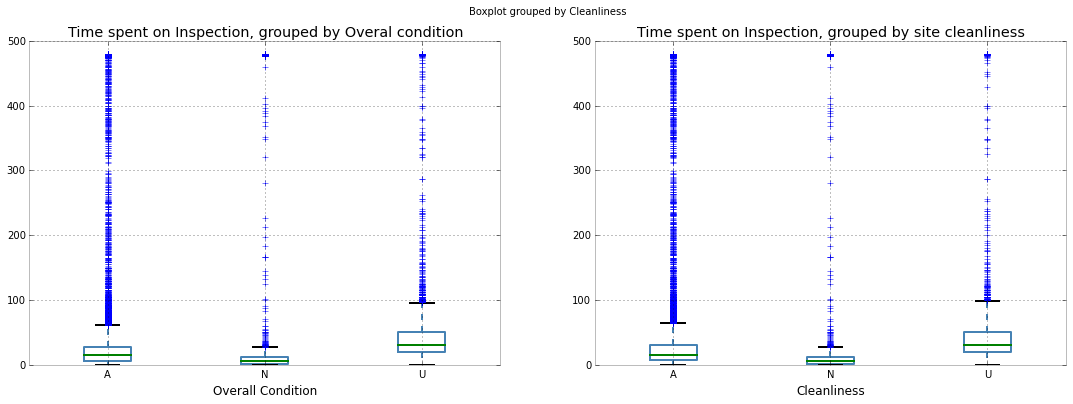

In [38]:
fig, axes = plt.subplots(1,2, figsize=(18,6))

df3.boxplot('timeSpent', by='Overall Condition',  ax=axes[0]);
df3.boxplot('timeSpent', by='Cleanliness',  ax=axes[1]);


axes[0].set_title('Time spent on Inspection, grouped by Overal condition')
axes[1].set_title('Time spent on Inspection, grouped by site cleanliness');
plt.savefig(PARQA + 'parqa/Inspections/img/time_spent.png')

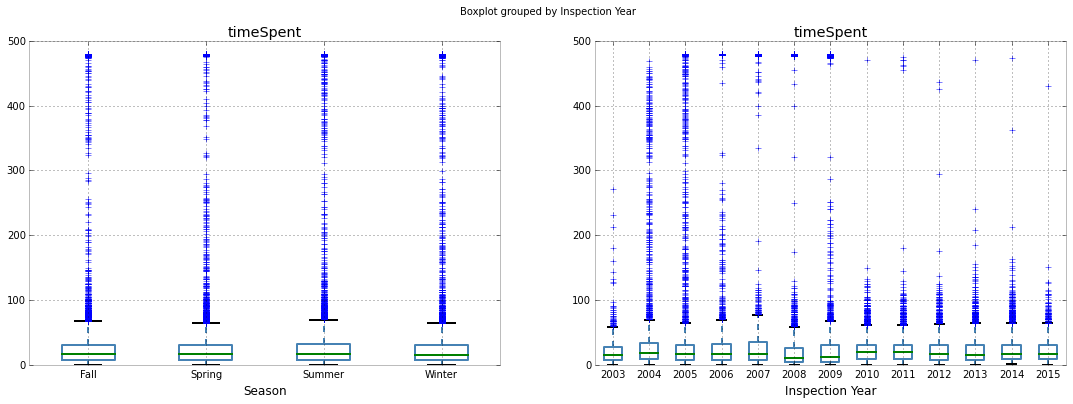

In [39]:
fig, axes = plt.subplots(1,2, figsize=(18,6))

df3.boxplot('timeSpent', by='Season',  ax=axes[0]);
df3.boxplot('timeSpent', by='Inspection Year',  ax=axes[1]);
plt.savefig(PARQA + 'parqa/Inspections/img/time_spent_season_year.png')

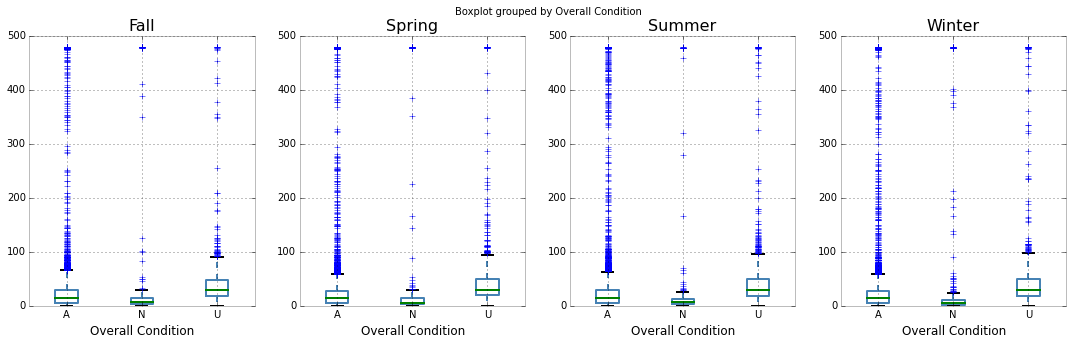

In [35]:
fig, axes = plt.subplots(1,4, figsize=(18,5))

for i, (name, g) in enumerate(df3.groupby('Season')):
    g.boxplot('timeSpent', by='Overall Condition',ax=axes[i]);
    axes[i].set_title(name, fontsize=16)

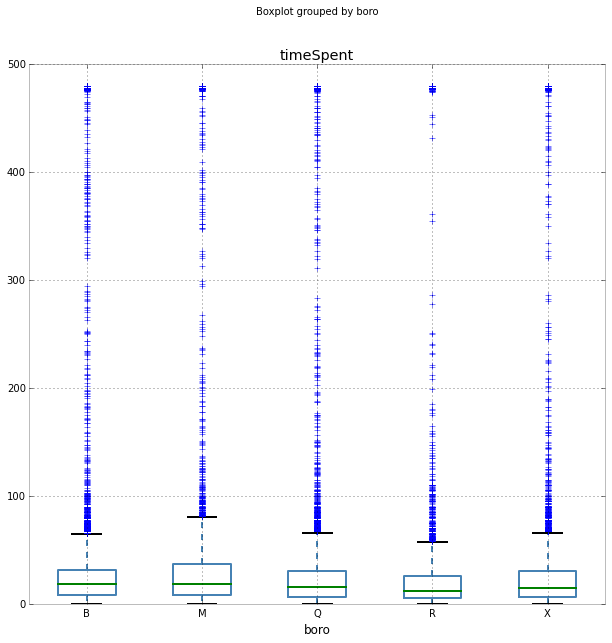

In [31]:
df3.boxplot('timeSpent',by='boro', figsize=(10,10))

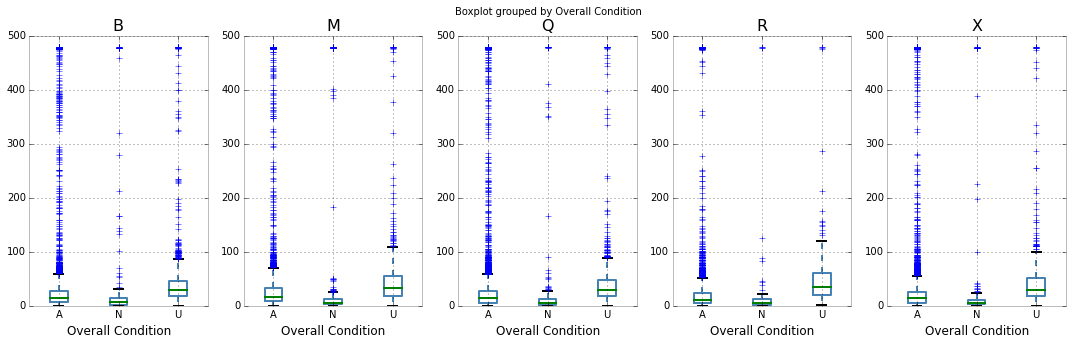

In [40]:
fig, axes = plt.subplots(1,5, figsize=(18,5))

for i, (name, g) in enumerate(df3.groupby('boro')):
    g.boxplot('timeSpent', by='Overall Condition',ax=axes[i]);
    axes[i].set_title(name, fontsize=16)

plt.savefig(PARQA + 'parqa/Inspections/img/time_spent_boro.png')

## KS2 Test

In [36]:
## Overal Condition

ocA = df3['timeSpent'][df3['Overall Condition']=='A']
ocU = df3['timeSpent'][df3['Overall Condition']=='U']

stats.ks_2samp(ocA, ocU)

Ks_2sampResult(statistic=0.34821232843606953, pvalue=0.0)

In [33]:
## Overal Condition

clA = df3['timeSpent'][df3['Cleanliness']=='A']
clU = df3['timeSpent'][df3['Cleanliness']=='U']

stats.ks_2samp(clA, clU)

Ks_2sampResult(statistic=0.32582254014893403, pvalue=0.0)

** Both times p-value seems to be way below any reasonable Alpha levels. **

In [34]:
## out of curiocity

M = df3['timeSpent'][df3['boro']=='M']
X = df3['timeSpent'][df3['boro']=='X']

stats.ks_2samp(M, X)

Ks_2sampResult(statistic=0.067679193546797856, pvalue=8.2782273691328924e-23)